In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import sklearn.metrics as metric

C:\Users\bhara\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_ITER = 500

In [3]:
df = pd.read_table("wine.data", delimiter=",", header=None)

In [4]:
def classification_accuracy(train_data, predicted_clusters, test_data):
    actual_labels = test_data.value_counts().index.tolist()
    train_data['predicted_clusters'] = predicted_clusters
    cluster_labels = pd.value_counts(pd.Series(predicted_clusters))
    cluster_labels = np.stack([cluster_labels.keys().values, cluster_labels.values]).T
    cluster_labels = cluster_labels.tolist()
    for i in range(len(cluster_labels)):
        cluster_labels[i].append(actual_labels[i])
    cluster_labels.sort()
    train_data['predicted_labels'] = list(map(lambda x : cluster_labels[x][2], train_data['predicted_clusters']))
    sum(train_data['predicted_labels']==test_data)
    accuracy = sum(train_data['predicted_labels']==test_data)/len(test_data)
    return accuracy

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
true_vals = df[0].value_counts().to_numpy()
true_vals

array([71, 59, 48], dtype=int64)

In [7]:
df2 = df.iloc[: , :1]
df2

,0
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [8]:
#df3 = df2[0]
#type(df3)
#df3

In [9]:
df = df.drop(columns = df.columns[0])
df

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [10]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


In [11]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_features_df)
pca_data

array([[ 3.31675081, -1.44346263],
       [ 2.20946492,  0.33339289],
       [ 2.51674015, -1.0311513 ],
       [ 3.75706561, -2.75637191],
       [ 1.00890849, -0.86983082],
       [ 3.05025392, -2.12240111],
       [ 2.44908967, -1.17485013],
       [ 2.05943687, -1.60896307],
       [ 2.5108743 , -0.91807096],
       [ 2.75362819, -0.78943767],
       [ 3.47973668, -1.30233324],
       [ 1.7547529 , -0.61197723],
       [ 2.11346234, -0.67570634],
       [ 3.45815682, -1.13062988],
       [ 4.31278391, -2.09597558],
       [ 2.3051882 , -1.66255173],
       [ 2.17195527, -2.32730534],
       [ 1.89897118, -1.63136888],
       [ 3.54198508, -2.51834367],
       [ 2.0845222 , -1.06113799],
       [ 3.12440254, -0.78689711],
       [ 1.08657007, -0.24174355],
       [ 2.53522408,  0.09184062],
       [ 1.64498834,  0.51627893],
       [ 1.76157587,  0.31714893],
       [ 0.9900791 , -0.94066734],
       [ 1.77527763, -0.68617513],
       [ 1.23542396,  0.08980704],
       [ 2.18840633,

In [12]:
pca_df = pd.DataFrame(pca_data)
pca_df

,0,1
0,3.316751,-1.443463
1,2.209465,0.333393
2,2.516740,-1.031151
3,3.757066,-2.756372
4,1.008908,-0.869831
...,...,...
173,-3.370524,-2.216289
174,-2.601956,-1.757229
175,-2.677839,-2.760899
176,-2.387017,-2.297347


In [13]:
label_encoder = preprocessing.LabelEncoder()
df2 = label_encoder.fit_transform(df2)
df3 = pd.DataFrame(df2)
df4 = df3[0]

C:\Users\bhara\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
'''model1 = GaussianMixture(n_components=3, init_params='random', max_iter=MAX_ITER)
model1.fit(df)
yhat1 = model1.predict(df)'''

"model1 = GaussianMixture(n_components=3, init_params='random', max_iter=MAX_ITER)\nmodel1.fit(df)\nyhat1 = model1.predict(df)"

In [15]:
def get_scores(n_components, init_params, max_iter, X, y, true_vals ):
    model = GaussianMixture(n_components=n_components, init_params=init_params, max_iter=max_iter, random_state=42)
    model.fit(X)
    yhat = model.predict(X)
    
    #df3 = df2[0]
    
    values = []
    for i in range(0,len(np.unique(y))):
        count = (yhat == i).sum()
        values.append(count)
    values.sort(reverse=True)
    pred_vals = np.array(values)
    err = abs(true_vals-pred_vals).sum()
    acc = abs( len(y)- err )/len(y)
    
    '''print(X)
    print(yhat)
    print('------------------')
    print(df3)'''
    
    acc2 = classification_accuracy(X, yhat,df4)
    
    print('silhouette_score:        ', metric.silhouette_score(X, yhat))
    print('davies_bouldin_score:    ', metric.davies_bouldin_score(X, yhat))
    print('calinski_harabasz_score: ', metric.calinski_harabasz_score(X, yhat))
    #print('Classification accuracy: ', acc)
    print('Classification accuracy2: ', acc2)
        
    

In [16]:
get_scores(n_components=3, init_params='random_from_data', max_iter=MAX_ITER, X=df, y=df2, true_vals=true_vals )

silhouette_score:         0.378486408594376
davies_bouldin_score:     0.6368697776591338
calinski_harabasz_score:  317.598790814045
Classification accuracy2:  0.702247191011236


In [17]:
get_scores(n_components=3, init_params='random_from_data', max_iter=MAX_ITER, X=scaled_features_df, y=df2, true_vals=true_vals )

silhouette_score:         0.1717114588023245
davies_bouldin_score:     2.1810820367114747
calinski_harabasz_score:  48.37708077001558
Classification accuracy2:  0.20786516853932585


In [18]:
get_scores(n_components=3, init_params='random_from_data', max_iter=MAX_ITER, X=pca_df, y=df2, true_vals=true_vals )

silhouette_score:         0.44517365945540394
davies_bouldin_score:     0.6524230882101039
calinski_harabasz_score:  124.3626726107583
Classification accuracy2:  0.17415730337078653


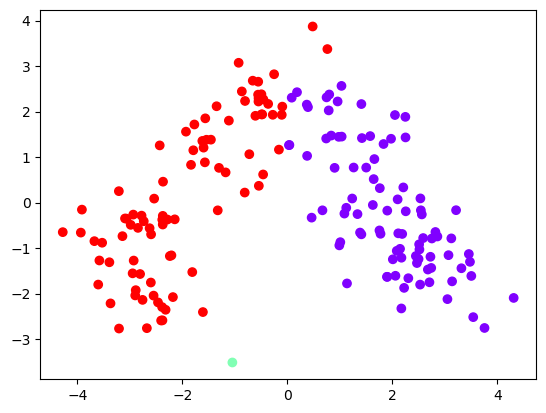

In [19]:
plt.scatter(pca_df[0], pca_df[1], c=pca_df['predicted_clusters'], cmap='rainbow')